In [1]:
import yaml
from TraceSimulator import TraceSimulator
import numpy as np
import matplotlib.pyplot as plt

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('config.yaml')
ts = TraceSimulator(config)

/home/dwong/software/TraceSimulator/TraceSimulator/TraceSimulator.py:185: RuntimeWarning: overflow encountered in exp
  self.template = np.concatenate([(np.exp((xs - self.trigger_time) / self.tau_rise))[xs <= self.trigger_time], (np.exp(-(xs - self.trigger_time) / self.tau_decay))[xs > self.trigger_time]])


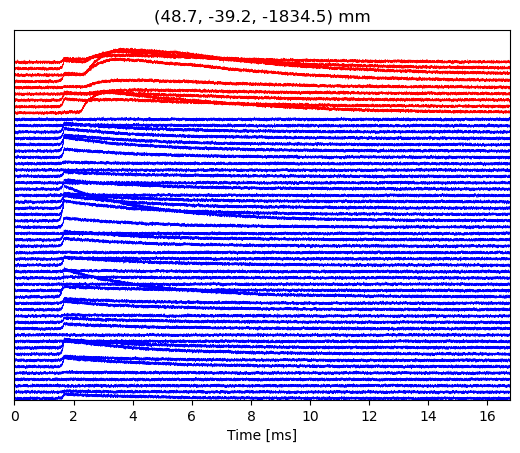

In [ ]:
trace, (x, y, z) = ts.generate(5890, type_recoil='NR') 
times = 0.5 * (ts.t_edges[1:] + ts.t_edges[:-1])
for i in range(54):
    if i > 44:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='r', lw=0.2)
    else:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='b', lw=0.2)
        
plt.xlim(0, np.max(times * 1e-6)), plt.xlabel('Time [ms]')
plt.ylim(-10), plt.yticks([])
plt.title(f'({x[0]:.1f}, {y[0]:.1f}, {z[0]:.1f}) mm');

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming trace is your data array with shape (1, 54, 32768)
trace = trace.squeeze()  # shape becomes (54, 32768)

fs = 1953125.0  # Sampling frequency in Hz (adjust if known)
dt = 1 / fs
N = trace.shape[1]


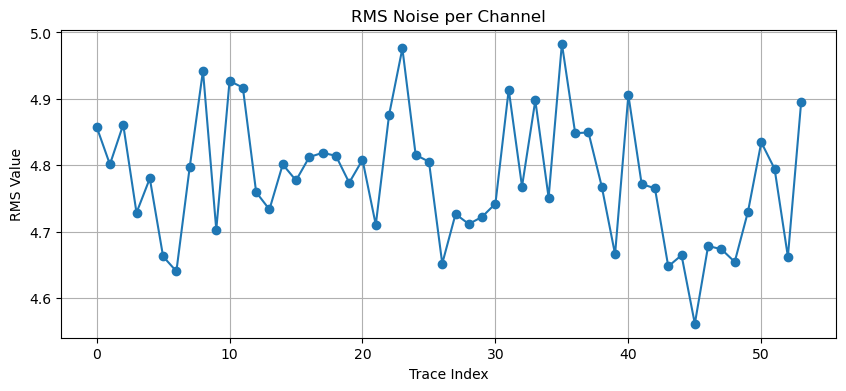

In [10]:
pre_trigger_samples = 2048
rms_per_trace = np.std(trace[:, :pre_trigger_samples], axis=1)

plt.figure(figsize=(10, 4))
plt.plot(rms_per_trace, marker='o')
plt.title('RMS Noise per Channel')
plt.xlabel('Trace Index')
plt.ylabel('RMS Value')
plt.grid(True)
plt.show()


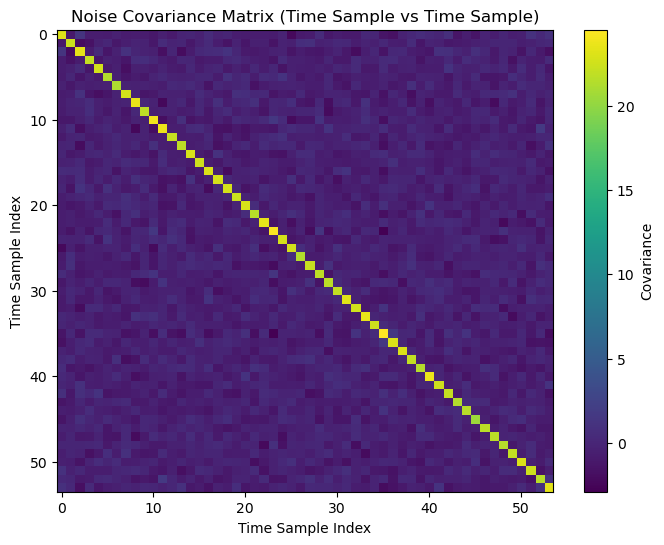

In [23]:
pre_trigger_samples = 2048
noise_data = trace[:, :pre_trigger_samples]  # shape (54, ~3276)

# Now we want the covariance matrix of the time samples
# So we transpose the data: shape becomes (samples, channels)
# And then compute covariance across traces
# Each row is a time sample, each column a different trace (channel)

noise_data_centered = noise_data - np.mean(noise_data, axis=0, keepdims=True)
cov_matrix = np.cov(noise_data_centered, rowvar=True)  # shape (samples, samples)
plt.figure(figsize=(8, 6))
plt.imshow(cov_matrix, aspect='auto', cmap='viridis')
plt.title('Noise Covariance Matrix (Time Sample vs Time Sample)')
plt.xlabel('Time Sample Index')
plt.ylabel('Time Sample Index')
plt.colorbar(label='Covariance')
plt.show()


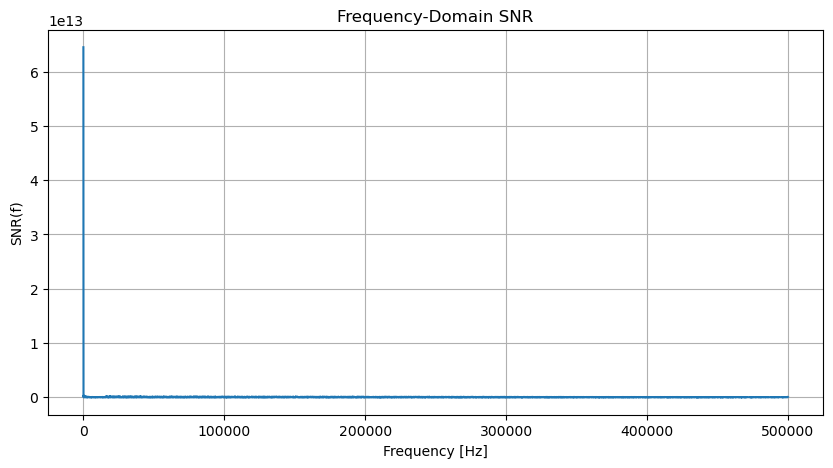

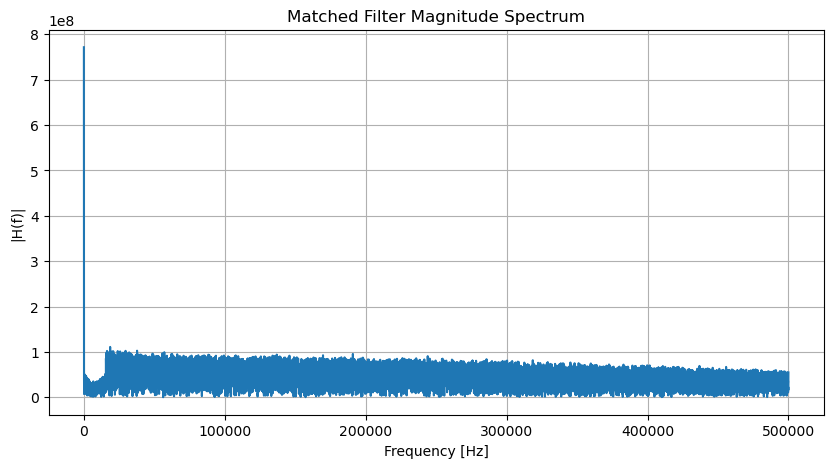

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Example placeholders (update these as needed)
fs = 1e6  # Hz
N = trace.shape[1]
dt = 1 / fs
freqs = np.fft.rfftfreq(N, dt)

# -- Step 1: Define or extract a signal template --
# We'll use the first trace as the "signal template" for demonstration
signal_template = trace[0]  # Replace with your known pulse shape

# -- Step 2: Compute FFT of the signal template --
window = np.hanning(N)
signal_fft = np.fft.rfft(signal_template * window)

# -- Step 3: Compute average noise PSD from multiple noise traces --
# We'll use first 10% of each trace assuming it's noise-only
pre_trigger_samples = int(0.1 * N)
noise_only_traces = trace[:, :pre_trigger_samples]

psd_list = []
for i in range(noise_only_traces.shape[0]):
    _, psd = welch(noise_only_traces[i], fs=fs, window='hann', nperseg=1024)
    psd_list.append(psd)

avg_psd = np.mean(psd_list, axis=0)

# Interpolate PSD to match FFT length of the signal
psd_interp = np.interp(freqs, freqs[:len(avg_psd)], avg_psd)

# -- Step 4: Compute frequency-domain SNR --
snr_freq = np.abs(signal_fft)**2 / psd_interp

# -- Step 5: Design matched filter --
matched_filter = np.conj(signal_fft) / psd_interp

# -- Step 6: Plotting --

plt.figure(figsize=(10, 5))
plt.plot(freqs, snr_freq)
plt.title("Frequency-Domain SNR")
plt.xlabel("Frequency [Hz]")
plt.ylabel("SNR(f)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(freqs, np.abs(matched_filter))
plt.title("Matched Filter Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(f)|")
plt.grid(True)
plt.show()


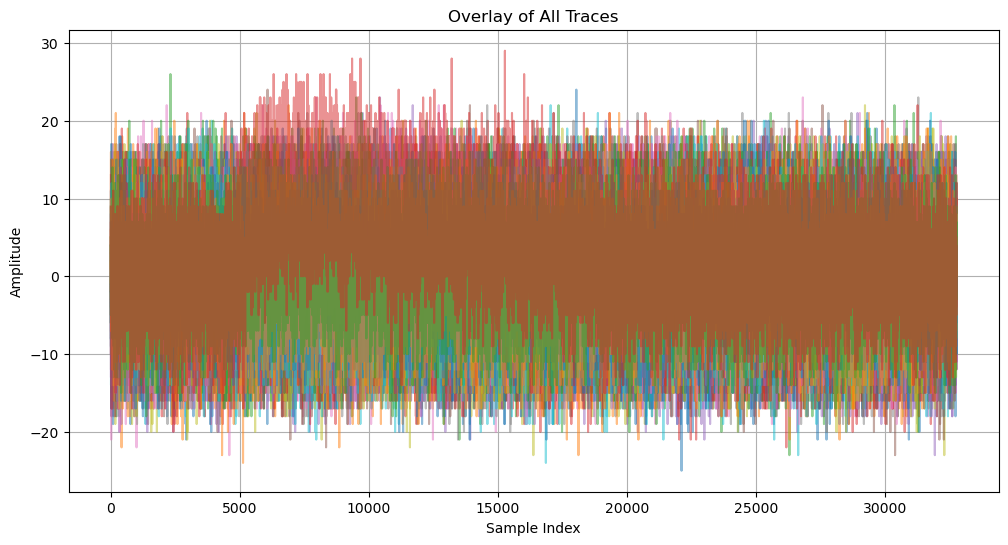

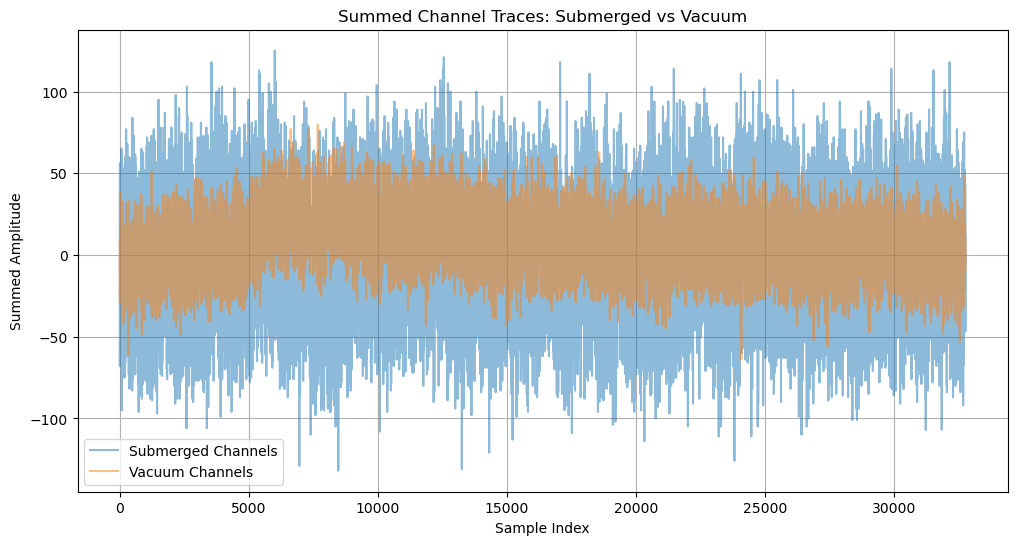

In [7]:
trace, (x, y, z) = ts.generate(175, type_recoil='NR')  # generate a 20 keV NR event

trace = trace.squeeze()  # shape becomes (54, 32768)

import numpy as np
import matplotlib.pyplot as plt

# Plot 1: Overlay of all traces
plt.figure(figsize=(12, 6))
for i in range(trace.shape[0]):
    plt.plot(trace[i], alpha=0.5)
plt.title('Overlay of All Traces')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Plot 2: Sum of submerged vs vacuum channels
sum_submerged = np.sum(trace[0:45], axis=0)  # Channels 0-40
sum_vacuum = np.sum(trace[45:], axis=0)    # Channels 41-50

plt.figure(figsize=(12, 6))
plt.plot(sum_submerged, label='Submerged Channels', alpha=0.5)
plt.plot(sum_vacuum, label='Vacuum Channels', alpha=0.5)
plt.title('Summed Channel Traces: Submerged vs Vacuum')
plt.xlabel('Sample Index')
plt.ylabel('Summed Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
trace, (x, y, z) = ts.generate(300, type_recoil='NR')  # generate a 20 keV NR event

trace = trace.squeeze()  # shape becomes (54, 32768)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch



N_uv: [0]
N_tr: [0]
N_ir: [0]
N_ph: [300000]


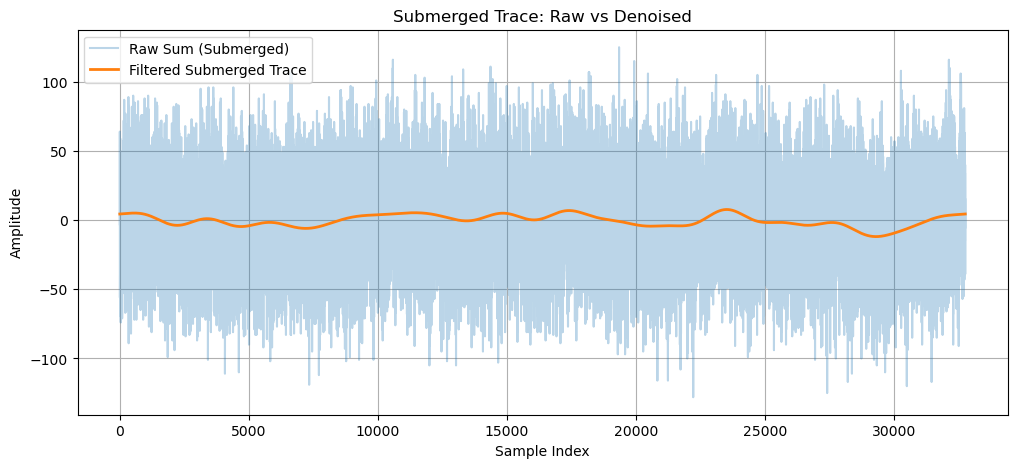

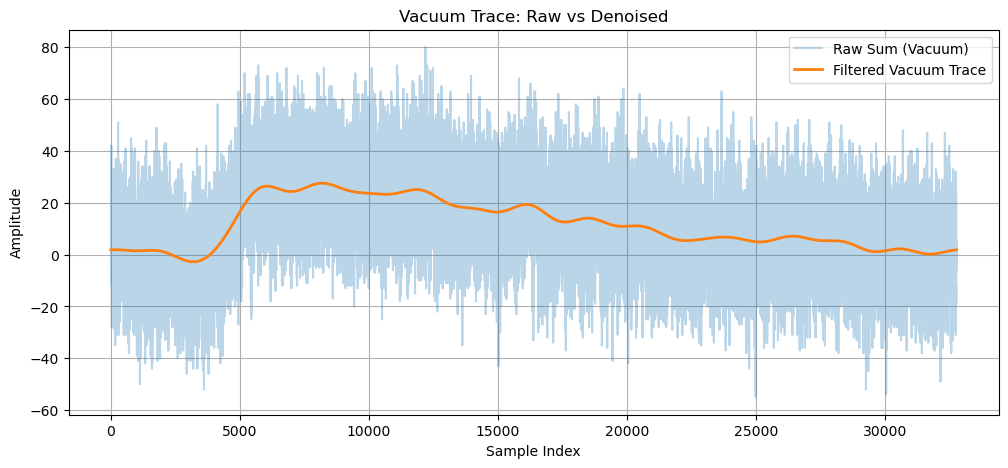

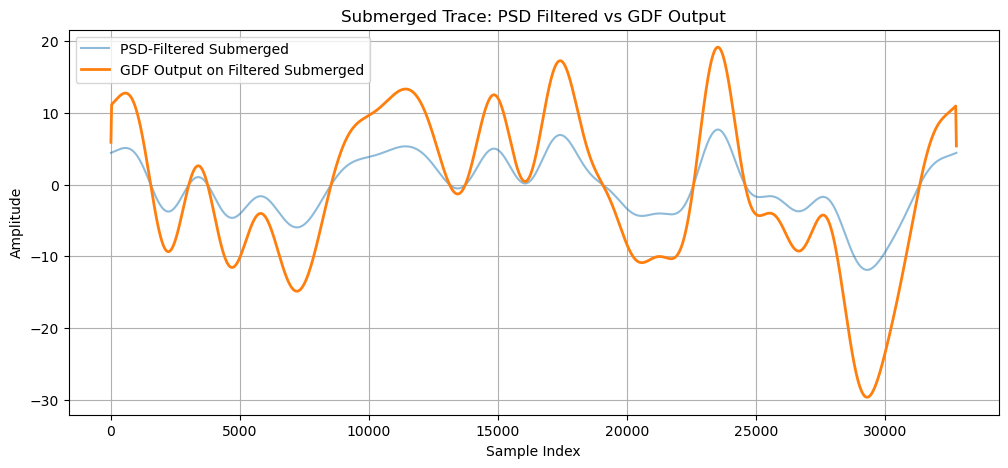

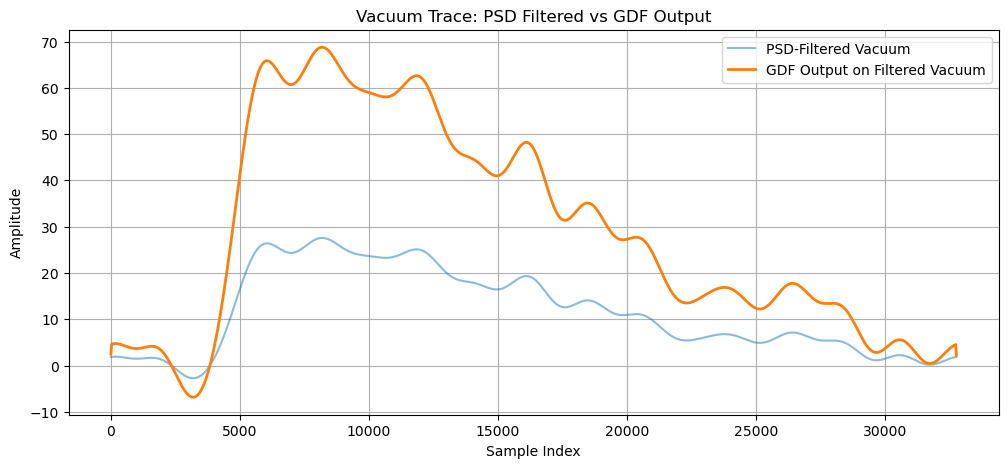

In [6]:
from scipy.signal import welch

fs = 1953125.0  # Sampling frequency in Hz (adjust if known)
N = trace.shape[1]

# Step 1: Sum of submerged channels (0–40)
sum_submerged = np.sum(trace[:45], axis=0)

# Step 2: Estimate PSD from noise (use pre-bump region)
pre_bump = sum_submerged[:2048]  # assume first 10k samples are noise
freqs, psd = welch(pre_bump, fs=fs, window='hann', nperseg=2048)

# Step 3: FFT of the submerged trace
freqs_full = np.fft.rfftfreq(N, 1/fs)
signal_fft_sub = np.fft.rfft(sum_submerged)

# Step 4: Interpolate PSD to match FFT length
psd_interp = np.interp(freqs_full, freqs, psd)

# Step 5: Apply PSD-based filter with frequency cutoff (submerged)
cutoff_freq = 1000  # Hz, adjust based on signal bandwidth
filter_mask = freqs_full < cutoff_freq
filtered_fft_sub = np.where(filter_mask, signal_fft_sub / psd_interp, 0)
filtered_fft_sub *= np.abs(signal_fft_sub[0]) / np.abs(filtered_fft_sub[0])  # normalize
filtered_trace_sub = np.fft.irfft(filtered_fft_sub, n=N)

# Step 6: Sum of vacuum channels (41–50)
sum_vacuum = np.sum(trace[45:], axis=0)
signal_fft_vac = np.fft.rfft(sum_vacuum)

# Step 7: Apply PSD-based filter with frequency cutoff (vacuum)
filtered_fft_vac = np.where(filter_mask, signal_fft_vac / psd_interp, 0)
filtered_fft_vac *= np.abs(signal_fft_vac[0]) / np.abs(filtered_fft_vac[0])  # normalize
filtered_trace_vac = np.fft.irfft(filtered_fft_vac, n=N)

# Step 8: Plot submerged trace separately
plt.figure(figsize=(12, 5))
plt.plot(sum_submerged, label='Raw Sum (Submerged)', alpha=0.3)
plt.plot(filtered_trace_sub, label='Filtered Submerged Trace', linewidth=2)
plt.title('Submerged Trace: Raw vs Denoised')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Step 9: Plot vacuum trace separately
plt.figure(figsize=(12, 5))
plt.plot(sum_vacuum, label='Raw Sum (Vacuum)', alpha=0.3)
plt.plot(filtered_trace_vac, label='Filtered Vacuum Trace', linewidth=2)
plt.title('Vacuum Trace: Raw vs Denoised')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Step 10: Generalized Delta Filter (GDF) visualization on filtered traces
# Compute residual noise covariance matrix from pre-bump region
pre_traces = trace[:, :2048]
noise_matrix = np.cov(pre_traces)
inv_noise_matrix = np.linalg.pinv(noise_matrix)  # pseudo-inverse for stability

gdf_vector = np.sum(inv_noise_matrix, axis=0)  # simplified projection direction

# Apply GDF to filtered submerged trace
filtered_gdf_sub = np.convolve(filtered_trace_sub, gdf_vector, mode='same')

plt.figure(figsize=(12, 5))
plt.plot(filtered_trace_sub, label='PSD-Filtered Submerged', alpha=0.5)
plt.plot(filtered_gdf_sub, label='GDF Output on Filtered Submerged', linewidth=2)
plt.title('Submerged Trace: PSD Filtered vs GDF Output')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Apply GDF to filtered vacuum trace
filtered_gdf_vac = np.convolve(filtered_trace_vac, gdf_vector, mode='same')

plt.figure(figsize=(12, 5))
plt.plot(filtered_trace_vac, label='PSD-Filtered Vacuum', alpha=0.5)
plt.plot(filtered_gdf_vac, label='GDF Output on Filtered Vacuum', linewidth=2)
plt.title('Vacuum Trace: PSD Filtered vs GDF Output')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()
